In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer 
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [15]:
target = 'vacc_h1n1_f'
# target = 'vacc_seas_f'
train = pd.merge(pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train.csv'), 
                 pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/train_labels.csv')[target], left_index=True, right_index=True)
test = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/test.csv')
sample_submission = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/vacc_flu/submission.csv')

In [16]:
train, val = train_test_split(train, train_size=0.80, test_size=0.20, 
                              stratify=train[target], random_state=2)


train.shape, val.shape, test.shape

((33723, 39), (8431, 39), (28104, 38))

In [17]:
# (참고) warning 제거를 위한 코드
np.seterr(divide='ignore', invalid='ignore')

def engineer(df):
    """특성을 엔지니어링 하는 함수입니다."""
    
    # h1n1_concern 결측치 처리 NaN -> 2 
    df.loc[:, "h1n1_concern"] = df.loc[:, "h1n1_concern"].fillna(2)
    
    
    # h1n1_knowledge 결측치 처리 NaN -> 1
    df.loc[:, "h1n1_knowledge"] = df.loc[:, "h1n1_knowledge"].fillna(1)
    
    
    # behaviorals에 대한 EDA
    behaviorals = [col for col in df.columns if 'behavioral' in col] 
    df['behaviorals'] = df[behaviorals].sum(axis=1)    

    
    # chronic_med_condition 결측치 처리 NaN -> 0
    df.loc[:, "chronic_med_condition"] = df.loc[:, "chronic_med_condition"].fillna(0)
    
#     해당 eda는 성적을 떨어트는 것으로 간주되어 주석처리
#     # healthss에 대한 EDA
#     df.loc[:, "health_insurance"] = df.loc[:, "health_insurance"].fillna(1)
#     df.loc[:, "health_worker"] = df.loc[:, "health_worker"].fillna(0)
#     healths = [col for col in df.columns if 'health' in col] 
#     df['healths'] = df[healths].sum(axis=1)    
   
    
    # opinion에 대한 EDA
    for column_opinion in [col for col in df.columns if 'opinion' in col]:
        df[column_opinion] = df[column_opinion].replace('Not at all effective',0).replace('Not Very Effective',1).replace('Don\'t know',2).replace('Somewhat effective',3).replace('Very effective',4)
        df[column_opinion] = df[column_opinion].replace('Very Low',0).replace('Somewhat low',1).replace('Don\'t know',2).replace('Somewhat high',3).replace('Very high',4)
        df[column_opinion] = df[column_opinion].replace('Not at all worried',0).replace('Not very worried',1).replace('Don\'t know',2).replace('Somewhat worried',3).replace('Very worried',4)    
    opinions = [col for col in df.columns if 'opinion' in col] 
    
#     해당 eda는 성적을 떨어트는 것으로 간주되어 주석처리    
#     #agegrp에 대한 EDA
#     df['agegrp'] = df['agegrp'].replace('6 Months - 9 Years',1).replace('10 - 17 Years',2).replace('18 - 34 Years',3).replace('35 - 44 Years',4).replace('45 - 54 Years',5).replace('55 - 64 Years',6).replace('65+ Years',7)
    
    
    #census_msa에 대한 EDA
    df["census_msa"] = df["census_msa"].replace("MSA, Not Principle City",1)
    df["census_msa"] = df["census_msa"].replace("MSA, Principle City",1)
    df["census_msa"] = df["census_msa"].replace("Non-MSA",1)
 
    
    # 높은 카디널리티를 가지는 특성을 제거합니다.
    selected_cols = df.select_dtypes(include=['number', 'object'])
    labels = selected_cols.nunique() # 특성별 카디널리티 리스트
    selected_features = labels[labels <= 30].index.tolist() # 카디널리티가 30보다 작은 특성만 선택합니다.
    df = df[selected_features]



    dels = [col for col in df.columns if ('employment' in col in col)]
#     dels = [col for col in df.columns if ('employment' in col or 'seas' in col)]
    df.drop(columns=dels, inplace=True)
        
    return df


train = engineer(train)
val = engineer(val)
test = engineer(test)

C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\user\anaconda3\lib\site-packages\pandas\core\frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [25]:
features = train.drop(columns=[target]).columns

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    RandomForestClassifier(n_estimators=500, 
                           max_depth=15, 
                           max_features=0.4, 
                           min_samples_leaf=20, 
                           random_state=42, 
                           n_jobs=-1, 
                           oob_score=True)
)

pipe.fit(X_train, y_train)
print('교체 검증 미포함한 정확도', pipe.score(X_val, y_val))
y_pred = pipe.predict(X_val)

# -------------------------------------------------------------

k = 5
scores = cross_val_score(pipe, X_train, y_train, cv=k)


print('교체 검증 포함한 정확도', scores.mean())

교체 검증 미포함한 정확도 0.7924326888862531
교체 검증 포함한 정확도 0.7799130105600828


In [26]:
scores = cross_val_score(pipe, X_val, y_val, cv=k)
y_pred = pipe.predict(X_test)

C:\Users\user\anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [27]:
sample_submission
sample_submission["vacc_h1n1_f"] = y_pred
sample_submission.to_csv("submission.csv", index=False)

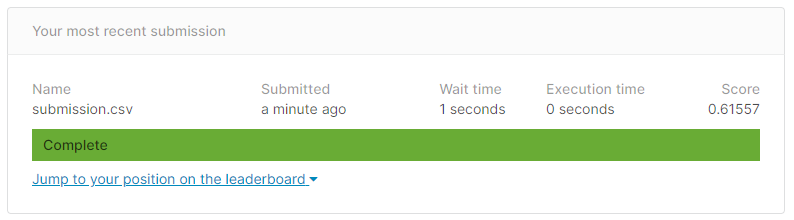

전 해당 점수에 만족합니다

설정조건  
RandomForestClassifier  
(n_estimators=1000,   
max_depth=15,   
max_features=0.4,   
min_samples_leaf=10,   
class_weight = 'balanced',   
random_state=42,   
n_jobs=-1,   
oob_score=True)